In [1]:
!git clone https://github.com/muxspace/facial_expressions.git

Cloning into 'facial_expressions'...
remote: Enumerating objects: 14214, done.
remote: Total 14214 (delta 0), reused 0 (delta 0), pack-reused 14214 (from 1)
Receiving objects: 100% (14214/14214), 239.65 MiB | 16.00 MiB/s, done.
Resolving deltas: 100% (223/223), done.
Updating files: 100% (13996/13996), done.


In [2]:
import csv
data = {}
with open('/content/facial_expressions/data/legend.csv') as f:
  reader = csv.reader(f)
  next(reader)
  for row in reader:
    key = row[2].lower()
    if key in data:
      data[key].append(row[1])
    else:
      data[key] = [row[1]]

In [3]:
emotion_list = list(data.keys())
emotion_list

['anger',
 'surprise',
 'disgust',
 'fear',
 'neutral',
 'happiness',
 'sadness',
 'contempt']

In [4]:
import os

os.mkdir('master_data')
os.mkdir('master_data/training')
os.mkdir('master_data/testing')

In [5]:
for emotion in emotion_list:
  os.mkdir(os.path.join('master_data/training/', emotion))
  os.mkdir(os.path.join('master_data/testing/', emotion))

In [6]:
from shutil import copyfile
split_size = 0.8

for emotion, images in data.items():
  train_size = int(split_size*len(images))
  train_images = images[:train_size]
  test_images = images[train_size:]
  for image in train_images:
    source = os.path.join('/content/facial_expressions/images', image)
    dest = os.path.join('/content/master_data/training', emotion, image)
    copyfile(source, dest)
  for image in test_images:
    source = os.path.join('/content/facial_expressions/images', image)
    dest = os.path.join('/content/master_data/testing', emotion, image)
    copyfile(source, dest)

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [9]:
model = tf.keras.models.Sequential([
      Conv2D(16, (3,3), activation='relu', input_shape = (100, 100, 3)),
      MaxPooling2D(2, 2),
      Conv2D(32, (3,3), activation='relu'),
      MaxPooling2D(2, 2),
      Conv2D(64, (3,3), activation='relu'),
      MaxPooling2D(2, 2),
      Flatten(),
      Dense(1024, activation='relu'),
      Dense(8, activation='softmax')
])
model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 98, 98, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 49, 49, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 47, 47, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       6,554,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,586,408 (25.13 MB)

 Trainable params: 6,586,408 (25.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
train_dir = '/content/master_data/training'
test_dir = '/content/master_data/testing'

train_datagen = ImageDataGenerator(rescale = 1.0/255)
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size = (100, 100),
                                                    class_mode = 'categorical',
                                                    batch_size = 128
                                                  )

test_datagen = ImageDataGenerator(rescale = 1.0/255)
test_generator = test_datagen.flow_from_directory(
                                                    test_dir,
                                                    target_size = (100, 100),
                                                    class_mode = 'categorical',
                                                    batch_size = 128
                                                  )

Found 10941 images belonging to 8 classes.
Found 2742 images belonging to 8 classes.


In [11]:
es = EarlyStopping(monitor='val_acc', patience = 2, min_delta=0.01)

In [13]:
model.fit(train_generator,
                    epochs = 10,
                    verbose = 1,
                    validation_data = test_generator,
                    callbacks = [es])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - acc: 0.4499 - loss: 1.8718 - val_acc: 0.5015 - val_loss: 1.0287
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - acc: 0.6010 - loss: 0.9597 - val_acc: 0.5244 - val_loss: 1.0580
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - acc: 0.7044 - loss: 0.8123 - val_acc: 0.6207 - val_loss: 0.9740
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - acc: 0.7360 - loss: 0.7365 - val_acc: 0.6010 - val_loss: 1.0593
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 170ms/step - acc: 0.7460 - loss: 0.7246 - val_acc: 0.6105 - val_loss: 1.1037


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step
Image No. | Predicted Expression | Actual Expression
--------------------------------------------------
     501 | happiness            | happiness
     502 | neutral              | happiness
     503 | happiness            | happiness
     504 | happiness            | happiness
     505 | neutral              | happiness
     506 | neutral              | happiness
     507 | happiness            | happiness
     508 | disgust              | happiness
     509 | happiness            | happiness
     510 | disgust              | happiness
     511 | disgust              | happiness
     512 | neutral              | happiness
     513 | disgust              | happiness
     514 | neutral              | happiness
     515 | happiness            | happiness
     516 | neutral              | happiness
     517 | happiness            | happiness
     518 | disgust              | happiness
     519 | neutral              | happiness
     520 | happines

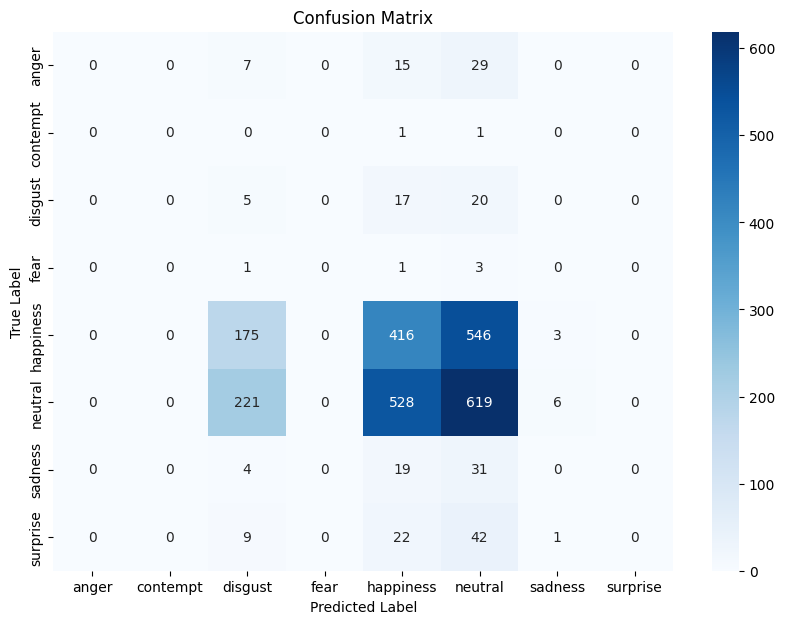


Classification Report:

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        51
    contempt       0.00      0.00      0.00         2
     disgust       0.01      0.12      0.02        42
        fear       0.00      0.00      0.00         5
   happiness       0.41      0.36      0.39      1140
     neutral       0.48      0.45      0.46      1374
     sadness       0.00      0.00      0.00        54
    surprise       0.00      0.00      0.00        74

    accuracy                           0.38      2742
   macro avg       0.11      0.12      0.11      2742
weighted avg       0.41      0.38      0.39      2742



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1200x500 with 0 Axes>

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class index
y_true = test_generator.classes  # True labels

# Map indices to actual class names
y_pred_labels = [class_labels[i] for i in y_pred_classes]
y_true_labels = [class_labels[i] for i in y_true]

# Get image filenames
filenames = test_generator.filenames

# Print first 20 comparisons (image number, predicted vs actual)
print("Image No. | Predicted Expression | Actual Expression")
print("-" * 50)
for i in range(500,520):  # Display first 20 predictions
    print(f"{i+1:8} | {y_pred_labels[i]:20} | {y_true_labels[i]}")

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Plot Accuracy & Loss Curves
history = model.history.history

plt.figure(figsize=(12, 5))

# Accuracy Graph
# plt.subplot(1, 2, 1)
# plt.plot(history["acc"], label="Train Accuracy")
# plt.plot(history["val_acc"], label="Validation Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.title("Model Accuracy")
# plt.legend()

# Loss Graph
# plt.subplot(1, 2, 2)
# plt.plot(history["loss"], label="Train Loss")
# plt.plot(history["val_loss"], label="Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Model Loss")
# plt.legend()

plt.show()
